# Import Basic Libraries

In [47]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

# Import libraries for ml methods
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef, f1_score

# Data loading

In [2]:
data = pd.read_csv('Hepatitis_C.csv')
data

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,label
0,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0
1,45,0,41.7,73.2,43.6,29.4,6.4,8.89,5.31,71.0,67.4,70.3,0
2,55,0,41.5,59.5,15.4,16.2,6.8,6.35,5.22,80.0,12.4,69.9,0
3,53,0,37.8,98.1,30.5,21.1,4.0,5.02,4.42,94.0,23.2,65.2,0
4,56,1,39.7,66.0,14.2,20.8,3.5,7.48,5.88,66.0,7.2,67.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,62,1,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5,1
200,64,1,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3,1
201,64,1,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0,1
202,46,1,33.0,62.7,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0,1


In [3]:
data.dtypes

Age        int64
Sex        int64
ALB      float64
ALP      float64
ALT      float64
AST      float64
BIL      float64
CHE      float64
CHOL     float64
CREA     float64
GGT      float64
PROT     float64
label      int64
dtype: object

### Missing data 

In [4]:
data.isnull().sum()

Age      0
Sex      0
ALB      0
ALP      0
ALT      0
AST      0
BIL      0
CHE      0
CHOL     0
CREA     0
GGT      0
PROT     0
label    0
dtype: int64

## Split data to X and y

In [8]:
X = data.drop('label', axis=1).copy()
y = data['label'].copy()

print(X.shape, y.shape)

(204, 12) (204,)


## Imbalanced Dataset

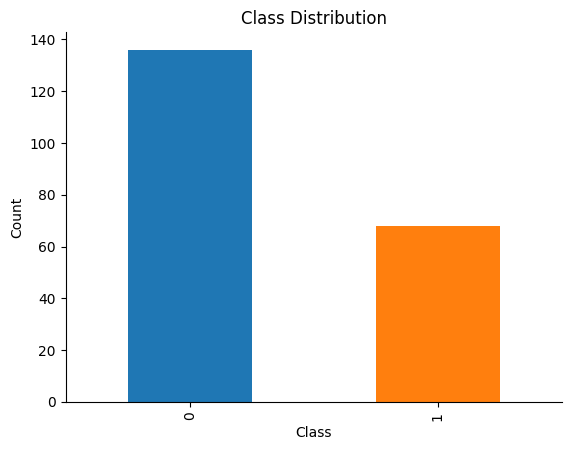

In [12]:
# Count classes and plot
target_count = y.value_counts()
ax = target_count.plot(kind='bar', title='Class Distribution', color=['#1f77b4','#ff7f0e'])
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [14]:
y.value_counts(normalize=True).round(2)

0    0.67
1    0.33
Name: label, dtype: float64

# Normalize data

Normalize only the numerical features

In [15]:
cat_features = ['Sex']

col_to_scale = X.drop(cat_features, axis=1).columns.values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X[col_to_scale] = scaler.fit_transform(X[col_to_scale])

print(X.shape, y.shape)

(204, 12) (204,)


### Define a dict of ML models to be studied

In [16]:
# Define classifiers
classifiers = {
    'LR':  LogisticRegression(max_iter=10000),
    'GNB': GaussianNB(),
    'kNN': KNeighborsClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'SVM': SVC()
}

### Define a dict of parameter grids

In [17]:
# Define hyperparameter grid for each model
LR_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
}

GNB_param_grid = {
    'var_smoothing': np.logspace(-13, -3, 100)
}

kNN_param_grid = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance']
}

LDA_param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
}

SVM_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Define the parameter grids
param_grids = {
    'LR': LR_param_grid,
    'GNB': GNB_param_grid,
    'kNN': kNN_param_grid,
    'LDA': LDA_param_grid,
    'SVM': SVM_param_grid
}

## Nested CV function

In [52]:
'''
    Define a function to perform the nested Cross Validation
'''
def nestedCV(model, p_grid, X, y):
    NUM_TRIALS = 10

    # Arrays to store scores
    nested_scores = []

    # Loop for each trial
    for i in tqdm(range(NUM_TRIALS)):
        
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=i)
        outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)

        # Nested CV with parameter optimization
        clf = GridSearchCV(estimator=model, scoring='f1_macro', param_grid=p_grid, 
                                 cv=inner_cv)
        
        nested_score = cross_val_score(clf, X=X, y=y, 
                                       scoring='matthews_corrcoef', cv=outer_cv)
        
        nested_scores.append(list(nested_score))
    return clf, nested_scores

In [53]:
nested_LG, nested_scores_LG = nestedCV(classifiers['LR'], param_grids['LR'], X, y)

nested_GNB, nested_scores_GNB = nestedCV(classifiers['GNB'], param_grids['GNB'], X, y)

nested_kNN, nested_scores_kNN = nestedCV(classifiers['kNN'], param_grids['kNN'], X, y)

nested_LDA, nested_scores_LDA = nestedCV(classifiers['LDA'], param_grids['LDA'], X, y)

nested_SVM, nested_scores_SVM = nestedCV(classifiers['SVM'], param_grids['SVM'], X, y)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:21<00:00, 14.14s/it]


In [69]:
nested_scores_LG = [item for sublist in nested_scores_LG for item in sublist]
nested_scores_GNB = [item for sublist in nested_scores_GNB for item in sublist]
nested_scores_kNN = [item for sublist in nested_scores_kNN for item in sublist]
nested_scores_LDA = [item for sublist in nested_scores_LDA for item in sublist]
nested_scores_SVM = [item for sublist in nested_scores_SVM for item in sublist]

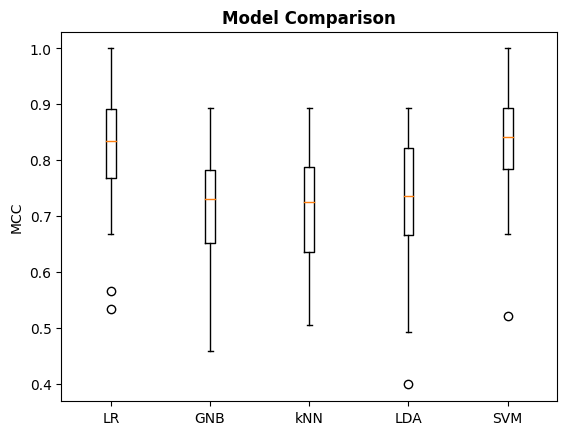

In [70]:
# create box plot
fig, ax = plt.subplots()
positions = [1, 2, 3, 4, 5] # x-axis positions for each box plot
ax.boxplot([nested_scores_LG, nested_scores_GNB, nested_scores_kNN, nested_scores_LDA, nested_scores_SVM], positions=positions, widths=0.1)

# add title and labels
ax.set_title('Model Comparison', fontweight='bold')
ax.set_ylabel('MCC')
ax.set_xticks(positions)
ax.set_xticklabels(['LR', 'GNB', 'kNN', 'LDA', 'SVM'])

# show plot
plt.show()

In [78]:
print('Mean score of 50 nCV outer loop folds for LR:'  ,sum(nested_scores_LG) / len(nested_scores_LG))
print('Mean score of 50 nCV outer loop folds for GNB:'  ,sum(nested_scores_GNB) / len(nested_scores_GNB))
print('Mean score of 50 nCV outer loop folds for kNN:'  ,sum(nested_scores_kNN) / len(nested_scores_kNN))
print('Mean score of 50 nCV outer loop folds for LDA:'  ,sum(nested_scores_LDA) / len(nested_scores_LDA))
print('Mean score of 50 nCV outer loop folds for SVM:'  ,sum(nested_scores_SVM) / len(nested_scores_SVM))

Mean score of 50 nCV outer loop folds for LR: 0.8200510363160523
Mean score of 50 nCV outer loop folds for GNB: 0.7232215582501884
Mean score of 50 nCV outer loop folds for kNN: 0.710184679335431
Mean score of 50 nCV outer loop folds for LDA: 0.7245147425883834
Mean score of 50 nCV outer loop folds for SVM: 0.8442386626049679


Finally, the  “winner”  classification algorithm in 10 trials of nCV is the `SVM`.

## Cross-Validation using the whole dataset

In [70]:
model = SVC()
SVM_param_grid = {
    'C': np.linspace(0.001, 10, 1000),
    'gamma': np.logspace(0.0001, 1, 1000),
    'kernel': ['linear', 'rbf']
}

# Perform grid search to find the best hyperparameters
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(model, param_distributions=SVM_param_grid,
                            scoring='matthews_corrcoef', n_iter=2000, cv=cv, verbose=1)
search.fit(X, y)

# Print the best hyperparameters and mean cross-validation score
print("Best parameters: ", search.best_params_)
print("Best score: ", search.best_score_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Best parameters:  {'kernel': 'linear', 'gamma': 6.650289333776228, 'C': 0.4013603603603604}
Best score:  0.867350780500612


In [71]:
# Save final model
final_model = search.best_estimator_

import pickle

filename = 'final_model.pkl'
pickle.dump(final_model, open(filename, 'wb'))

# Load the model from disk

loaded_model = pickle.load(open(filename, 'rb'))